In [1]:
"""Automated Rectification of Image.

References
----------
1.  Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
2.  Bazin, Jean-Charles, and Marc Pollefeys. "3-line RANSAC for orthogonal
    vanishing point detection." 2012 IEEE/RSJ International Conference on
    Intelligent Robots and Systems. IEEE, 2012.
"""
from skimage import feature, color, transform, io
import numpy as np
import logging


def compute_edgelets(image, sigma=3):
    """Create edgelets as in the paper.

    Uses canny edge detection and then finds (small) lines using probabilstic
    hough transform as edgelets.

    Parameters
    ----------
    image: ndarray
        Image for which edgelets are to be computed.
    sigma: float
        Smoothing to be used for canny edge detection.

    Returns
    -------
    locations: ndarray of shape (n_edgelets, 2)
        Locations of each of the edgelets.
    directions: ndarray of shape (n_edgelets, 2)
        Direction of the edge (tangent) at each of the edgelet.
    strengths: ndarray of shape (n_edgelets,)
        Length of the line segments detected for the edgelet.
    """
    gray_img = color.rgb2gray(image)
    edges = feature.canny(gray_img, sigma)
    lines = transform.probabilistic_hough_line(edges, line_length=3,
                                               line_gap=2)

    locations = []
    directions = []
    strengths = []

    for p0, p1 in lines:
        p0, p1 = np.array(p0), np.array(p1)
        locations.append((p0 + p1) / 2)
        directions.append(p1 - p0)
        strengths.append(np.linalg.norm(p1 - p0))

    # convert to numpy arrays and normalize
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)

    directions = np.array(directions) / \
        np.linalg.norm(directions, axis=1)[:, np.newaxis]

    return (locations, directions, strengths)


def edgelet_lines(edgelets):
    """Compute lines in homogenous system for edglets.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.

    Returns
    -------
    lines: ndarray of shape (n_edgelets, 3)
        Lines at each of edgelet locations in homogenous system.
    """
    locations, directions, _ = edgelets
    normals = np.zeros_like(directions)
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1)
    return lines


def compute_votes(edgelets, model, threshold_inlier=5):
    """Compute votes for each of the edgelet against a given vanishing point.

    Votes for edgelets which lie inside threshold are same as their strengths,
    otherwise zero.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    model: ndarray of shape (3,)
        Vanishing point model in homogenous cordinate system.
    threshold_inlier: float
        Threshold to be used for computing inliers in degrees. Angle between
        edgelet direction and line connecting the  Vanishing point model and
        edgelet location is used to threshold.

    Returns
    -------
    votes: ndarry of shape (n_edgelets,)
        Votes towards vanishing point model for each of the edgelet.

    """
    vp = model[:2] / model[2]

    locations, directions, strengths = edgelets

    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * \
        np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5

    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))

    theta_thresh = threshold_inlier * np.pi / 180
    return (theta < theta_thresh) * strengths


def ransac_vanishing_point(edgelets, num_ransac_iter=2000, threshold_inlier=5):
    """Estimate vanishing point using Ransac.

    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    num_ransac_iter: int
        Number of iterations to run ransac.
    threshold_inlier: float
        threshold to be used for computing inliers in degrees.

    Returns
    -------
    best_model: ndarry of shape (3,)
        Best model for vanishing point estimated.

    Reference
    ---------
    Chaudhury, Krishnendu, Stephen DiVerdi, and Sergey Ioffe.
    "Auto-rectification of user photos." 2014 IEEE International Conference on
    Image Processing (ICIP). IEEE, 2014.
    """
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 2]

    best_model = None
    best_votes = np.zeros(num_pts)

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]

        current_model = np.cross(l1, l2)

        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # reject degenerate candidates
            continue

        current_votes = compute_votes(
            edgelets, current_model, threshold_inlier)

        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            logging.info("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))

    return best_model


def ransac_3_line(edgelets, focal_length, num_ransac_iter=2000,
                  threshold_inlier=5):
    """Estimate orthogonal vanishing points using 3 line Ransac algorithm.

    Assumes camera has been calibrated and its focal length is known.
    Parameters
    ----------
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    focal_length: float
        Focal length of the camera used.
    num_ransac_iter: int
        Number of iterations to run ransac.
    threshold_inlier: float
        threshold to be used for computing inliers in degrees.

    Returns
    -------
    vp1: ndarry of shape (3,)
        Estimated model for first vanishing point.
    vp2: ndarry of shape (3,)
        Estimated model for second vanishing point, which is orthogonal to
        first vanishing point.

    Reference
    ---------
    Bazin, Jean-Charles, and Marc Pollefeys. "3-line RANSAC for orthogonal
    vanishing point detection." 2012 IEEE/RSJ International Conference on
    Intelligent Robots and Systems. IEEE, 2012.
    """
    locations, directions, strengths = edgelets
    lines = edgelet_lines(edgelets)

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5]
    second_index_space = arg_sort[:num_pts // 5]
    third_index_space = arg_sort[:num_pts // 2]

    best_model = (None, None)
    best_votes = 0

    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space)
        ind2 = np.random.choice(second_index_space)
        ind3 = np.random.choice(third_index_space)

        l1 = lines[ind1]
        l2 = lines[ind2]
        l3 = lines[ind3]

        vp1 = np.cross(l1, l2)
        # The vanishing line polar to v1
        h = np.dot(vp1, [1 / focal_length**2, 1 / focal_length**2, 1])
        vp2 = np.cross(h, l3)

        if np.sum(vp1**2) < 1 or vp1[2] == 0:
            # reject degenerate candidates
            continue

        if np.sum(vp2**2) < 1 or vp2[2] == 0:
            # reject degenerate candidates
            continue

        vp1_votes = compute_votes(edgelets, vp1, threshold_inlier)
        vp2_votes = compute_votes(edgelets, vp2, threshold_inlier)
        current_votes = (vp1_votes > 0).sum() + (vp2_votes > 0).sum()

        if current_votes > best_votes:
            best_model = (vp1, vp2)
            best_votes = current_votes
            logging.info("Current best model has {} votes at iteration {}".format(
                current_votes, ransac_iter))

    return best_model


def reestimate_model(model, edgelets, threshold_reestimate=5):
    """Reestimate vanishing point using inliers and least squares.

    All the edgelets which are within a threshold are used to reestimate model

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
        All edgelets from which inliers will be computed.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    restimated_model: ndarry of shape (3,)
        Reestimated model for vanishing point in homogenous coordinates.
    """
    locations, directions, strengths = edgelets

    inliers = compute_votes(edgelets, model, threshold_reestimate) > 0
    locations = locations[inliers]
    directions = directions[inliers]
    strengths = strengths[inliers]

    lines = edgelet_lines((locations, directions, strengths))

    a = lines[:, :2]
    b = -lines[:, 2]
    est_model = np.linalg.lstsq(a, b)[0]
    return np.concatenate((est_model, [1.]))


def remove_inliers(model, edgelets, threshold_inlier=10):
    """Remove all inlier edglets of a given model.

    Parameters
    ----------
    model: ndarry of shape (3,)
        Vanishing point model in homogenous coordinates which is to be
        reestimated.
    edgelets: tuple of ndarrays
        (locations, directions, strengths) as computed by `compute_edgelets`.
    threshold_inlier: float
        threshold to be used for finding inlier edgelets.

    Returns
    -------
    edgelets_new: tuple of ndarrays
        All Edgelets except those which are inliers to model.
    """
    inliers = compute_votes(edgelets, model, 10) > 0
    locations, directions, strengths = edgelets
    locations = locations[~inliers]
    directions = directions[~inliers]
    strengths = strengths[~inliers]
    edgelets = (locations, directions, strengths)
    return edgelets


def compute_homography_and_warp(image, vp1, vp2, clip=True, clip_factor=3):
    """Compute homography from vanishing points and warp the image.

    It is assumed that vp1 and vp2 correspond to horizontal and vertical
    directions, although the order is not assumed.
    Firstly, projective transform is computed to make the vanishing points go
    to infinty so that we have a fronto parellel view. Then,Computes affine
    transfom  to make axes corresponding to vanishing points orthogonal.
    Finally, Image is translated so that the image is not missed. Note that
    this image can be very large. `clip` is provided to deal with this.

    Parameters
    ----------
    image: ndarray
        Image which has to be wrapped.
    vp1: ndarray of shape (3, )
        First vanishing point in homogenous coordinate system.
    vp2: ndarray of shape (3, )
        Second vanishing point in homogenous coordinate system.
    clip: bool, optional
        If True, image is clipped to clip_factor.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    Returns
    -------
    warped_img: ndarray
        Image warped using homography as described above.
    """
    # Find Projective Transform
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # Translate so that whole of the image is covered
    inter_matrix = np.dot(A, H)

    cords = np.dot(inter_matrix, [[0, 0, image.shape[1], image.shape[1]],
                                  [0, image.shape[0], 0, image.shape[0]],
                                  [1, 1, 1, 1]])
    cords = cords[:2] / cords[2]

    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    final_homography = np.dot(T, inter_matrix)

    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img


def vis_edgelets(image, edgelets, show=True):
    """Helper function to visualize edgelets."""
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    locations, directions, strengths = edgelets
    for i in range(locations.shape[0]):
        xax = [locations[i, 0] - directions[i, 0] * strengths[i] / 2,
               locations[i, 0] + directions[i, 0] * strengths[i] / 2]
        yax = [locations[i, 1] - directions[i, 1] * strengths[i] / 2,
               locations[i, 1] + directions[i, 1] * strengths[i] / 2]

        plt.plot(xax, yax, 'r-')

    if show:
        plt.show()


def vis_model(image, model, show=True):
    """Helper function to visualize computed model."""
    import matplotlib.pyplot as plt
    edgelets = compute_edgelets(image)
    locations, directions, strengths = edgelets
    inliers = compute_votes(edgelets, model, 10) > 0

    edgelets = (locations[inliers], directions[inliers], strengths[inliers])
    locations, directions, strengths = edgelets
    vis_edgelets(image, edgelets, False)
    vp = model / model[2]
    plt.plot(vp[0], vp[1], 'bo')
    for i in range(locations.shape[0]):
        xax = [locations[i, 0], vp[0]]
        yax = [locations[i, 1], vp[1]]
        plt.plot(xax, yax, 'b-.')

    if show:
        plt.show()


def rectify_image(image, clip_factor=6, algorithm='independent', 
                  reestimate=False):
    """Rectified image with vanishing point computed using ransac.

    Parameters
    ----------
    image: ndarray
        Image which has to be rectified.
    clip_factor: float, optional
        Proportion of image in multiples of image size to be retained if gone
        out of bounds after homography.
    algorithm: one of {'3-line', 'independent'}
        independent ransac algorithm finds the orthogonal vanishing points by
        applying ransac twice.
        3-line algorithm finds the orthogonal vanishing points together, but
        assumes knowledge of focal length.
    reestimate: bool
        If ransac results are to be reestimated using least squares with
        inlers. Turn this off if getting bad results.
    Returns
    -------
    warped_img: ndarray
        Rectified image.
    """
    if type(image) is not np.ndarray:
        image = io.imread(image)

    # Compute all edgelets.
    edgelets1 = compute_edgelets(image)

    if algorithm == 'independent':
        # Find first vanishing point
        vp1 = ransac_vanishing_point(edgelets1, 2000, threshold_inlier=5)
        if reestimate:
            vp1 = reestimate_model(vp1, edgelets1, 5)

        # Remove inlier to remove dominating direction.
        edgelets2 = remove_inliers(vp1, edgelets1, 10)

        # Find second vanishing point
        vp2 = ransac_vanishing_point(edgelets2, 2000, threshold_inlier=5)
        if reestimate:
            vp2 = reestimate_model(vp2, edgelets2, 5)
    elif algorithm == '3-line':
        focal_length = None
        vp1, vp2 = ransac_3_line(edgelets1, focal_length,
                                 num_ransac_iter=3000, threshold_inlier=5)
    else:
        raise KeyError(
            "Parameter 'algorithm' has to be one of {'3-line', 'independent'}")

    # Compute the homography and warp
    warped_img = compute_homography_and_warp(image, vp1, vp2,
                                             clip_factor=clip_factor)

    return warped_img





In [2]:
import sys
import matplotlib.pyplot as plt

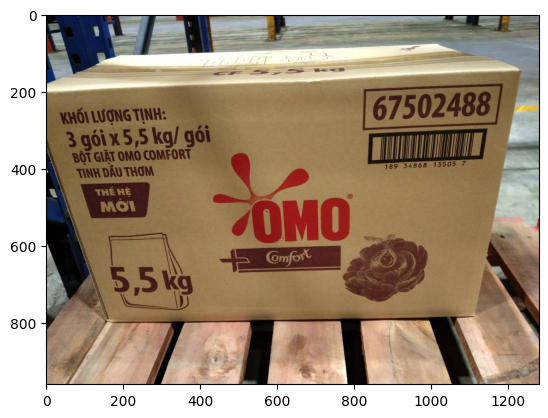

C:\Users\huydq\AppData\Local\Temp\ipykernel_24380\816372455.py:121: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.abs(cosine_theta))


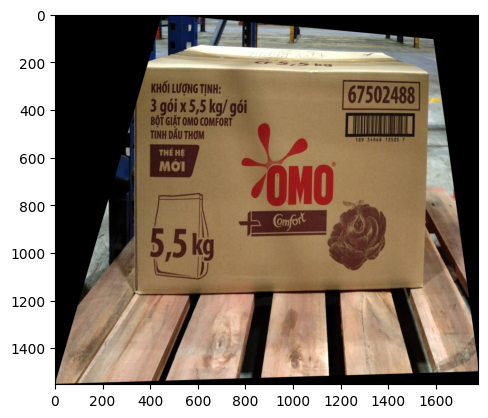

In [10]:

image_name = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_1.jpg"
image = io.imread(image_name)

#print("Rectifying {}".format(image_name))
#save_name = '.'.join(image_name.split('.')[:-1]) + '_warped.png'
#io.imsave(save_name, )
result = rectify_image(image_name, 6, algorithm='independent')

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(result)
plt.show()
